# Travaux pratiques 2

**Année: 2024-2025**

## Objectifs

1. **Modélisation de connaissances et interrogation de données** : Utiliser un langage logique pour structurer une base de connaissances et créer des règles permettant d’extraire des informations spécifiques à partir des données.

2. **Classification de textes et d'images** : Concevoir et entraîner des modèles de réseaux de neurones pour la classification de textes (exercice 2.2) et d'images (exercice 2.4), en maîtrisant le prétraitement des données, l'optimisation des hyperparamètres, et l'évaluation des performances des modèles.

3. **Prédiction de séquences** : Développer un modèle de prédiction pour des séquences de traductions, en appliquant des techniques de préparation de données séquentielles et en évaluant les performances du modèle sur des données de test.

- Faits
    - `eleve(Nom, Prenom, DateNaissance)`: Informations personnelles des élèves.
    - `groupe_projet(Eleve, Groupe)`: Groupes de projet auxquels les élèves appartiennent.
    - `note(Eleve, Module, Note)`: Notes des élèves dans différents modules.
    - `module(NomModule, Description)`: Liste des modules avec leur nom et description.
- Règles
    - `eleves_groupe(Groupe, Eleves)`: Trouver tous les élèves d’un groupe de projet spécifique.
    - `moyenne_notes(Eleve, Module, Moyenne)`: Calculer la moyenne des notes d’un élève dans un module.
    - `modules_suivis(Eleve, Modules)`: Lister les modules suivis par un élève.

- Exemples de requetes pour questionner la base de connaissance:
    - `?- eleves_groupe('Groupe1', Eleves).`
    - `?- moyenne_notes('Dupont', 'Math', Moyenne).`
    - `?- modules_suivis('Martin', Modules).`


# Exercice 2.2

In [32]:
%pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets.reuters import load_data
from tensorflow.keras.preprocessing.sequence import pad_sequences

(x_train, y_train), (x_test, y_test) = load_data(num_words=10000)

Exemple de séquence d'entraînement après tokenisation et padding :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label correspondant :
3


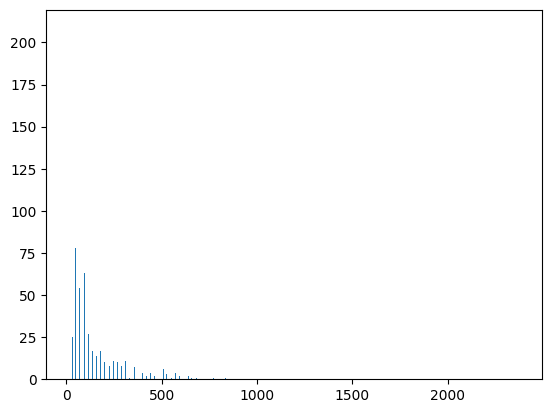

In [2]:
x_train_lenths = [len(x) for x in x_train]
plt.hist(x_train_lenths, bins=len(x_train_lenths))

max_words = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)

word_index = tf.keras.datasets.reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text])

train_sequences = tokenizer.sequences_to_texts(x_train)
test_sequences = tokenizer.sequences_to_texts(x_test)

train_sequences = tokenizer.texts_to_sequences(train_sequences)
test_sequences = tokenizer.texts_to_sequences(test_sequences)

maxlen = 256
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

print("Exemple de séquence d'entraînement après tokenisation et padding :")
print(train_padded[0])
print("Label correspondant :")
print(y_train[0])

1. **Chargement et prétraitement des données** : 
   - Chargez le jeu de données **Reuters** à l’aide de `tf.keras.datasets.reuters`.
   - Prétraitez les données en veillant à convertir les textes en séquences de tokens numériques compatibles avec le modèle. Utilisez des techniques comme la tokenisation et le padding pour obtenir des séquences de longueur uniforme.
   - **Conseils** : Utilisez `Tokenizer` de `tf.keras.preprocessing.text` pour transformer les textes en séquences numériques et `pad_sequences` pour uniformiser la longueur des séquences.

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import reuters

# Chargement des données Reuters
(num_words, test_split) = 10000, 0.2  # Configurations
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=num_words, test_split=test_split)

# Convertir les indices de mots en texte brut pour pouvoir appliquer Tokenizer
word_index = reuters.get_word_index()
index_to_word = {value: key for key, value in word_index.items()}
train_text = [" ".join([index_to_word.get(i - 3, "?")
                       for i in item]) for item in train_data]
test_text = [" ".join([index_to_word.get(i - 3, "?")
                      for i in item]) for item in test_data]

# Initialisation du Tokenizer
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_text)

# Transformation des textes en séquences numériques
train_sequences = tokenizer.texts_to_sequences(train_text)
test_sequences = tokenizer.texts_to_sequences(test_text)

# Application du padding pour uniformiser la longueur des séquences
# Optionnel : définir une longueur max

# Calcul d'une longueur de séquence optimale (par exemple, 95e percentile)
sequence_lengths = [len(seq) for seq in train_sequences]
max_length = int(np.percentile(sequence_lengths, 95))  # 95e percentile

# Application du padding avec cette longueur maximale
train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Vérification des nouvelles dimensions
print("Taille des séquences train :", train_padded.shape)
print("Taille des séquences test :", test_padded.shape)

Taille des séquences train : (8982, 442)
Taille des séquences test : (2246, 442)


2. **Construction d’un modèle de réseau de neurones** : 
   - Créez un modèle de réseau de neurones profond pour la classification des textes. Expérimentez avec différents types de couches pour trouver une architecture adaptée (par exemple, couches d'embedding pour les mots, couches denses, ou couches LSTM ou GRU pour capturer la structure des séquences).
   - **Conseils** : Essayez d’abord une architecture simple (comme une combinaison d’Embedding et Dense), puis explorez l’ajout de couches récurrentes pour une meilleure compréhension du contexte des mots.

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D

# Paramètres du modèle
vocab_size = 10000  # Correspond à num_words dans Tokenizer
embedding_dim = 64  # Taille de la représentation des mots en vecteurs denses
num_classes = max(train_labels) + 1  # Nombre de classes de sortie

# Modèle de base
# Modèle de base
model_1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Construction explicite du modèle (si nécessaire)
model_1.build(input_shape=(None, max_length))

# Compilation du modèle
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model_1.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 442, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,254 (2.50 MB)

 Trainable params: 654,254 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU

# Paramètres du modèle
vocab_size = 10000  # Nombre de mots uniques dans le vocabulaire
embedding_dim = 64  # Dimension des vecteurs d'Embedding
max_length = 442  # Longueur des séquences après padding
num_classes = 46  # Nombre de classes pour la classification

# Construction du modèle
model_2 = Sequential([
    # Couche d'Embedding : initialisation correcte avec tous les paramètres
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              input_length=max_length),

    # Couche LSTM : ajustement des unités et définition du return_sequences
    LSTM(128, return_sequences=False),  # Utilisation de 128 unités dans l'LSTM

    # Première couche Dense : activation ReLU
    Dense(128, activation='relu'),

    # Couche de sortie Dense : avec softmax pour la classification multi-classes
    Dense(num_classes, activation='softmax')
])

# Construction explicite du modèle (si nécessaire)
model_2.build(input_shape=(None, max_length))

# Compiler le modèle avec l'optimiseur et la fonction de perte
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Afficher un résumé du modèle pour voir si tout est bien initialisé
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 442, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 761,262 (2.90 MB)

 Trainable params: 761,262 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten

# Paramètres du modèle
vocab_size = 10000  # Nombre de mots uniques dans le vocabulaire
embedding_dim = 64  # Dimension des vecteurs d'Embedding
max_length = 442  # Longueur des séquences après padding
num_classes = 46  # Nombre de classes pour la classification

# Construction du modèle
model_3 = Sequential([
    # Couche d'Embedding : initialisation correcte avec tous les paramètres
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              input_length=max_length),

    # Couche LSTM : ajustement des unités et définition du return_sequences
    Flatten(),  # Utilisation de 128 unités dans l'LSTM

    # Première couche Dense : activation ReLU
    Dense(128, activation='relu'),

    # Couche de sortie Dense : avec softmax pour la classification multi-classes
    Dense(num_classes, activation='softmax')
])

# Construction explicite du modèle (si nécessaire)
model_3.build(input_shape=(None, max_length))

# Compiler le modèle avec l'optimiseur et la fonction de perte
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Afficher un résumé du modèle pour voir si tout est bien initialisé
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 442, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,620,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,266,926 (16.28 MB)

 Trainable params: 4,266,926 (16.28 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Entraînement du modèle de base
history_1 = model_1.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_data=(test_padded, test_labels))

# Entraînement du modèle avec LSTM
history_2 = model_2.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_data=(test_padded, test_labels))

# Entraînement du modèle avec Flatten
history_3 = model_3.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_data=(test_padded, test_labels))


Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3589 - loss: 2.5956 - val_accuracy: 0.3829 - val_loss: 2.2652
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4692 - loss: 2.0691 - val_accuracy: 0.5583 - val_loss: 1.8569
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5666 - loss: 1.7696 - val_accuracy: 0.6331 - val_loss: 1.6318
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6277 - loss: 1.5530 - val_accuracy: 0.6541 - val_loss: 1.4720
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6819 - loss: 1.3254 - val_accuracy: 0.6892 - val_loss: 1.3429
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7179 - loss: 1.1904 - val_accuracy: 0.6995 - val_loss: 1.3021
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7324 - loss: 1.1043 - val_accuracy: 0.7208 - val_loss: 1.2025
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7602 - loss: 1.0001 - val_accuracy: 0.

# Cherchons maintenant les meilleurs hyper paramètres pour notre modèle

In [28]:
# Entraînement du modèle avec des hyperparamètres ajustés
history = model_rnn.fit(train_padded, train_labels,
                    epochs=20,       # Nombre d'époques
                    batch_size=64,   # Taille du batch
                    # Validation sur l'ensemble de validation
                    validation_data=(test_padded, test_labels),
                    verbose=2)       # Affichage détaillé

Epoch 1/20
141/141 - 2s - 15ms/step - accuracy: 0.5505 - loss: 1.8458 - val_accuracy: 0.6518 - val_loss: 1.4683
Epoch 2/20
141/141 - 2s - 11ms/step - accuracy: 0.7619 - loss: 1.0109 - val_accuracy: 0.7271 - val_loss: 1.2163
Epoch 3/20
141/141 - 2s - 11ms/step - accuracy: 0.8936 - loss: 0.4985 - val_accuracy: 0.7453 - val_loss: 1.1677
Epoch 4/20
141/141 - 2s - 12ms/step - accuracy: 0.9428 - loss: 0.2751 - val_accuracy: 0.7431 - val_loss: 1.1943
Epoch 5/20
141/141 - 2s - 11ms/step - accuracy: 0.9515 - loss: 0.2108 - val_accuracy: 0.7302 - val_loss: 1.2027
Epoch 6/20
141/141 - 2s - 12ms/step - accuracy: 0.9506 - loss: 0.1830 - val_accuracy: 0.7306 - val_loss: 1.2438
Epoch 7/20
141/141 - 2s - 11ms/step - accuracy: 0.9534 - loss: 0.1551 - val_accuracy: 0.7337 - val_loss: 1.2373
Epoch 8/20
141/141 - 2s - 11ms/step - accuracy: 0.9538 - loss: 0.1482 - val_accuracy: 0.7329 - val_loss: 1.1976
Epoch 9/20
141/141 - 2s - 11ms/step - accuracy: 0.9531 - loss: 0.1413 - val_accuracy: 0.7373 - val_loss:

In [30]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Définir un planificateur de taux d'apprentissage (par exemple, diviser par 10 tous les 5 époques)


def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        return lr * 0.1  # Diviser le taux d'apprentissage par 10
    return lr


# Appliquer le planificateur lors de l'entraînement
lr_scheduler = LearningRateScheduler(scheduler)

# Entraîner avec le planificateur
history = model_rnn.fit(train_padded, train_labels,
                    epochs=20,
                    batch_size=64,
                    validation_data=(test_padded, test_labels),
                    verbose=2,
                    callbacks=[lr_scheduler])  # Utiliser le planificateur

Epoch 1/20
141/141 - 2s - 12ms/step - accuracy: 0.9548 - loss: 0.0886 - val_accuracy: 0.7391 - val_loss: 1.3609 - learning_rate: 0.0010
Epoch 2/20
141/141 - 2s - 11ms/step - accuracy: 0.9565 - loss: 0.0859 - val_accuracy: 0.7431 - val_loss: 1.3115 - learning_rate: 0.0010
Epoch 3/20
141/141 - 2s - 12ms/step - accuracy: 0.9548 - loss: 0.0863 - val_accuracy: 0.7373 - val_loss: 1.3154 - learning_rate: 0.0010
Epoch 4/20
141/141 - 2s - 12ms/step - accuracy: 0.9555 - loss: 0.0866 - val_accuracy: 0.7467 - val_loss: 1.2935 - learning_rate: 0.0010
Epoch 5/20
141/141 - 2s - 11ms/step - accuracy: 0.9565 - loss: 0.0783 - val_accuracy: 0.7337 - val_loss: 1.3911 - learning_rate: 0.0010
Epoch 6/20
141/141 - 2s - 12ms/step - accuracy: 0.9663 - loss: 0.0604 - val_accuracy: 0.7413 - val_loss: 1.4020 - learning_rate: 1.0000e-04
Epoch 7/20
141/141 - 2s - 12ms/step - accuracy: 0.9669 - loss: 0.0562 - val_accuracy: 0.7422 - val_loss: 1.4115 - learning_rate: 1.0000e-04
Epoch 8/20
141/141 - 2s - 11ms/step - ac

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

# Définir l'early stopping pour arrêter l'entraînement si la validation n'améliore plus la performance
early_stopping = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True)

history = model_rnn.fit(train_padded, train_labels,
                        epochs=20,
                        batch_size=64,
                        validation_data=(test_padded, test_labels),
                        verbose=2,
                        callbacks=[early_stopping])  # Utiliser le planificateur

Epoch 1/20
141/141 - 2s - 12ms/step - accuracy: 0.9683 - loss: 0.0495 - val_accuracy: 0.7409 - val_loss: 1.4738
Epoch 2/20
141/141 - 2s - 12ms/step - accuracy: 0.9682 - loss: 0.0495 - val_accuracy: 0.7409 - val_loss: 1.4740
Epoch 3/20
141/141 - 2s - 12ms/step - accuracy: 0.9683 - loss: 0.0495 - val_accuracy: 0.7409 - val_loss: 1.4742
Epoch 4/20
141/141 - 2s - 11ms/step - accuracy: 0.9684 - loss: 0.0495 - val_accuracy: 0.7409 - val_loss: 1.4746
